In [632]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
from sklearn import preprocessing, model_selection, linear_model, ensemble, pipeline, metrics, decomposition
sns.set()

### Data

In [2]:
train_data = pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [ ]:
train_data.describe()

### Initial EDA

- Read data-description.txt.
- Visualise distribution of response variable: `SalePrice`.
- Identify categorical, ordinal and numerical variables.
- Visualise the relationships between the predictors and the response variable.
- Visualise distributions of predictors with missing values in the training set - in anticipation of the next job to be done; sensible imputation.

#### Response: Saleprice

In [ ]:
_, (ax1, ax2) = plt.subplots(figsize=(15,10), ncols=2)
sns.distplot(train_data['SalePrice'], ax=ax1)
sns.distplot(np.log(train_data['SalePrice']), ax=ax2)

#### Predictors: Categorical, Numerical and Ordinal

In [3]:
categoricals = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 
                'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                'MoSold', 'SaleType', 'SaleCondition', 'MiscFeature']

numericals = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
              'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
              '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
              'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
              'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
              '3SsnPorch', 'ScreenPorch', 'PoolArea','YrSold', 'MiscVal', 'OverallQual',
             'OverallCond']

ordinals = ['LotShape', 'LandSlope',
            'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
            'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
            'PavedDrive', 'PoolQC', 'Fence']

# dropping
# - `Utilities` as there is only one example in train with label different to the others.

In [ ]:
sns.stripplot(x='Utilities', y='SalePrice', data=train_data)

##### Categoricals

In [ ]:
train_data[categoricals].head()

In [ ]:
_, axes = plt.subplots(nrows=len(categoricals), figsize=(7.5, 150))
for idx, c in enumerate(categoricals):
    ax = sns.stripplot(x=c, y='SalePrice', data=train_data, ax=axes[idx])

In [ ]:
train_data[categoricals].isna().sum()

##### Ordinals

In [ ]:
train_data[ordinals].head()

In [ ]:
_, axes = plt.subplots(nrows=len(ordinals), figsize=(7.5, 150))
for idx, c in enumerate(ordinals):
    ax = sns.stripplot(x=c, y='SalePrice', data=train_data, ax=axes[idx])

In [ ]:
train_data[ordinals].isna().sum()

##### Numericals

In [ ]:
train_data[numericals].head()

In [ ]:
_, axes = plt.subplots(nrows=len(numericals), figsize=(7.5, 150))
for idx, c in enumerate(numericals):
    ax = sns.scatterplot(x=c, y='SalePrice', data=train_data, ax=axes[idx])

In [ ]:
train_data[numericals].isna().sum()

In [ ]:
(train_data[numericals] == 0).sum()

In [ ]:
sns.distplot(train_data['LotFrontage'].dropna())

In [ ]:
sns.distplot(train_data['GarageYrBlt'].dropna())

In [ ]:
sns.distplot(train_data['MasVnrArea'].dropna())

### Preprocessing I

- Impute missing data
- Sensible values for ordinal predictors

#### Imputation

In [5]:
def impute_missing(X):
    df = X.copy()
    
    # categoricals
    df['Alley'] = df['Alley'].fillna('missing')
    df['GarageType'] = df['GarageType'].fillna('missing')
    df['MiscFeature'] = df['MiscFeature'].fillna('missing')
    # assume that if this is missing, there isn't any masonry
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    # these aren't missing for any obs in the training set, but are each missing for small number of obs in test
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

    # ordinals
    df['FireplaceQu'] = df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])
    df['Electrical'] =  df['Electrical'].fillna(df['Electrical'].mode()[0])
    # .. garage/pool/fence NAs, correspond to no garage/pool/fence according to data_description.txt
    df['GarageFinish'] = df['GarageFinish'].fillna('NA')
    df['GarageCond'] = df['GarageCond'].fillna('NA')
    df['GarageQual'] = df['GarageQual'].fillna('NA')
    df['PoolQC'] = df['PoolQC'].fillna('NA')
    df['Fence'] = df['Fence'].fillna('NA')
    # .. assuming same for basements
    df['BsmtQual'] = df['BsmtQual'].fillna('NA')
    df['BsmtCond'] = df['BsmtCond'].fillna('NA')
    df['BsmtExposure'] = df['BsmtExposure'].fillna('NA')
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NA')
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NA')
    # these aren't missing for any obs in the training set, but are each missing for small number of obs in test
    df['KitchenQual'] =  df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    df['Functional'] =  df['Functional'].fillna(df['Functional'].mode()[0])
    
    # numericals
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median()) # is there a better way.. feature engineer year bins and never?
    df['MasVnrArea'] =  df['MasVnrArea'].fillna(df['MasVnrArea'].median())
    # these aren't missing for any obs in the training set, but are each missing for small number of obs in test
    # they all pertain to garages and basements; I'm going to assume that these facilities don't exist if these
    # values are missing
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
    df['BsmtUnfSF'] = df['BsmtFinSF2'].fillna(0)
    df['TotalBsmtSF'] = df['BsmtFinSF2'].fillna(0)
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
    df['GarageCars'] = df['GarageCars'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    return df    

In [ ]:
impute_missing(train_data).head()

In [ ]:
train_data[categoricals].isna().sum()

#### Ordinals

In [4]:
def qual_ordinal_score(x):
    '''BsmtQual, GarageQual, PoolQC, FireplaceQu, BsmtCond, GarageCond'''
    if x == 'Ex':
        return 5
    elif x == 'Gd':
        return 4
    elif x == 'TA':
        return 3
    elif x =='Fa':
        return 2
    elif x =='Po':
        return 1
    elif x == 'NA':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))

def bsmt_exposure_ordinal_score(x):
    '''BsmtExposure'''
    if x == 'Gd':
        return 4
    elif x == 'Av':
        return 3
    elif x =='Mn':
        return 2
    elif x =='No':
        return 1
    elif x == 'NA':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))

def bsmt_fin_type_ordinal_score(x):
    '''BsmtExposure'''
    if x == 'GLQ':
        return 6
    elif x == 'ALQ':
        return 5
    elif x =='BLQ':
        return 4
    elif x =='Rec':
        return 3
    elif x == 'LwQ':
        return 2
    elif x == 'Unf':
        return 1
    elif x == 'NA':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))
        
def garage_finish_ordinal_score(x):
    '''GarageFinish'''
    if x == 'Fin':
        return 3
    elif x == 'RFn':
        return 2
    elif x =='Unf':
        return 1
    elif x == 'NA':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))
        
def fence_ordinal_score(x):
    '''Fence'''
    if x == 'GdPrv':
        return 4
    elif x == 'MnPrv':
        return 3
    elif x =='GdWo':
        return 2
    elif x == 'MnWw':
        return 1
    elif x == 'NA':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))
    
def lot_shape_ordinal_score(x):
    '''LotShape'''
    if x == 'Reg':
        return 0
    elif x == 'IR1':
        return 1
    elif x =='IR2':
        return 2
    elif x == 'IR3':
        return 3
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))
    
def land_slope_ordinal(x):
    '''LandSlope'''
    if x == 'Gtl':
        return 0
    elif x == 'Mod':
        return 1
    elif x =='Sev':
        return 2
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))
        
def electrical_ordinal(x):
    '''Electrical'''
    if x == 'SBrkr':
        return 4
    elif x == 'FuseA':
        return 3
    elif x =='FuseF':
        return 2
    elif x == 'FuseP':
        return 1
    elif x == 'Mix':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))

def functional_ordinal(x):
    '''Functional'''
    if x == 'Typ':
        return 7
    elif x == 'Min1':
        return 6
    elif x =='Min2':
        return 5
    elif x =='Mod':
        return 4
    elif x == 'Maj1':
        return 3
    elif x == 'Maj2':
        return 2
    elif x == 'Sev':
        return 1
    elif x == 'Sal':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))    

def paved_ordinal(x):
    '''PavedDrive'''
    if x == 'Y':
        return 2
    elif x == 'P':
        return 1
    elif x == 'N':
        return 0
    else:
        raise ValueError('UNEXPECTED VALUE: {}'.format(x))    
        
ordinal_extractor_map = {'LotShape' : lot_shape_ordinal_score,
                         'LandSlope' : land_slope_ordinal,
                         'BsmtQual' : qual_ordinal_score,
                         'BsmtCond' : qual_ordinal_score,
                         'BsmtExposure' : bsmt_exposure_ordinal_score,
                         'BsmtFinType1' : bsmt_fin_type_ordinal_score,
                         'BsmtFinType2' : bsmt_fin_type_ordinal_score,
                         'HeatingQC' : qual_ordinal_score,
                         'Electrical' : electrical_ordinal,
                         'KitchenQual' : qual_ordinal_score,
                         'Functional' : functional_ordinal,
                         'FireplaceQu' : qual_ordinal_score,
                         'GarageFinish' :  garage_finish_ordinal_score,
                         'GarageQual' : qual_ordinal_score,
                         'GarageCond' : qual_ordinal_score,
                         'PavedDrive' : paved_ordinal,
                         'PoolQC' : qual_ordinal_score,
                         'Fence' : fence_ordinal_score}

def extract_ordinals(X):
    return pd.DataFrame([X[k].apply(f) for k, f in ordinal_extractor_map.items()]).T

In [ ]:
extract_ordinals(impute_missing(train_data)).head()

### More EDA
- High level view: a pairplot and correlation matrix.
- Investigate distributions of numerical predictors; in anticipation of transforming skewed ones to be normal.
- Investigate non-linearities in relationships with outcome variable: in anticipation of adding polynomial features.
- Investigate anomolies; in aniticpation of removing them.

In [ ]:
numericals_df = impute_missing(train_data)[numericals]
numericals_df.head()

In [ ]:
sns.pairplot(numericals_df)

In [ ]:
_, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(numericals_df.corr(), annot=True, ax=ax)

#### Distribution investigation

In [ ]:
_, axes = plt.subplots(nrows=len(numericals), figsize=(25,125))
for idx, n in enumerate(numericals_df.columns):
    sns.distplot(numericals_df[n], ax=axes[idx])

#### Anomaly investigation

In [ ]:
oq_outliers = (train_data['OverallQual'] == 4) & (train_data['SalePrice'] > 200000)

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25, 10))
sns.scatterplot(x='OverallQual', y='SalePrice', data=train_data, ax=ax1)
sns.scatterplot(x='OverallQual', y='SalePrice', data=train_data[~oq_outliers], ax=ax2)

In [ ]:
gt_outliers = (train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 200000)

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25, 10))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data, ax=ax1)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data[~gt_outliers], ax=ax2)

### Diagnostics

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


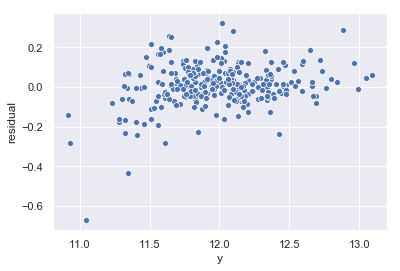

In [680]:
labelled_X, labelled_y = preprocessing_pipeline_train(train_data.drop(['SalePrice'], axis=1), train_data['SalePrice'])
train_X, test_X, train_y, test_y = model_selection.train_test_split(labelled_X, labelled_y, test_size=0.2)

p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso(0.0004275510204081633))]).fit(train_X, train_y)

preds = p.predict(test_X)
resids = test_y - preds
scatter_df = pd.DataFrame({'residual' : resids, 'y': test_y})
sns.scatterplot(x='y', y='residual', data=scatter_df)

In [681]:
p = ensemble.GradientBoostingRegressor(max_depth=1, learning_rate=0.015, loss='huber', n_estimators=1000).fit(train_X, train_y)

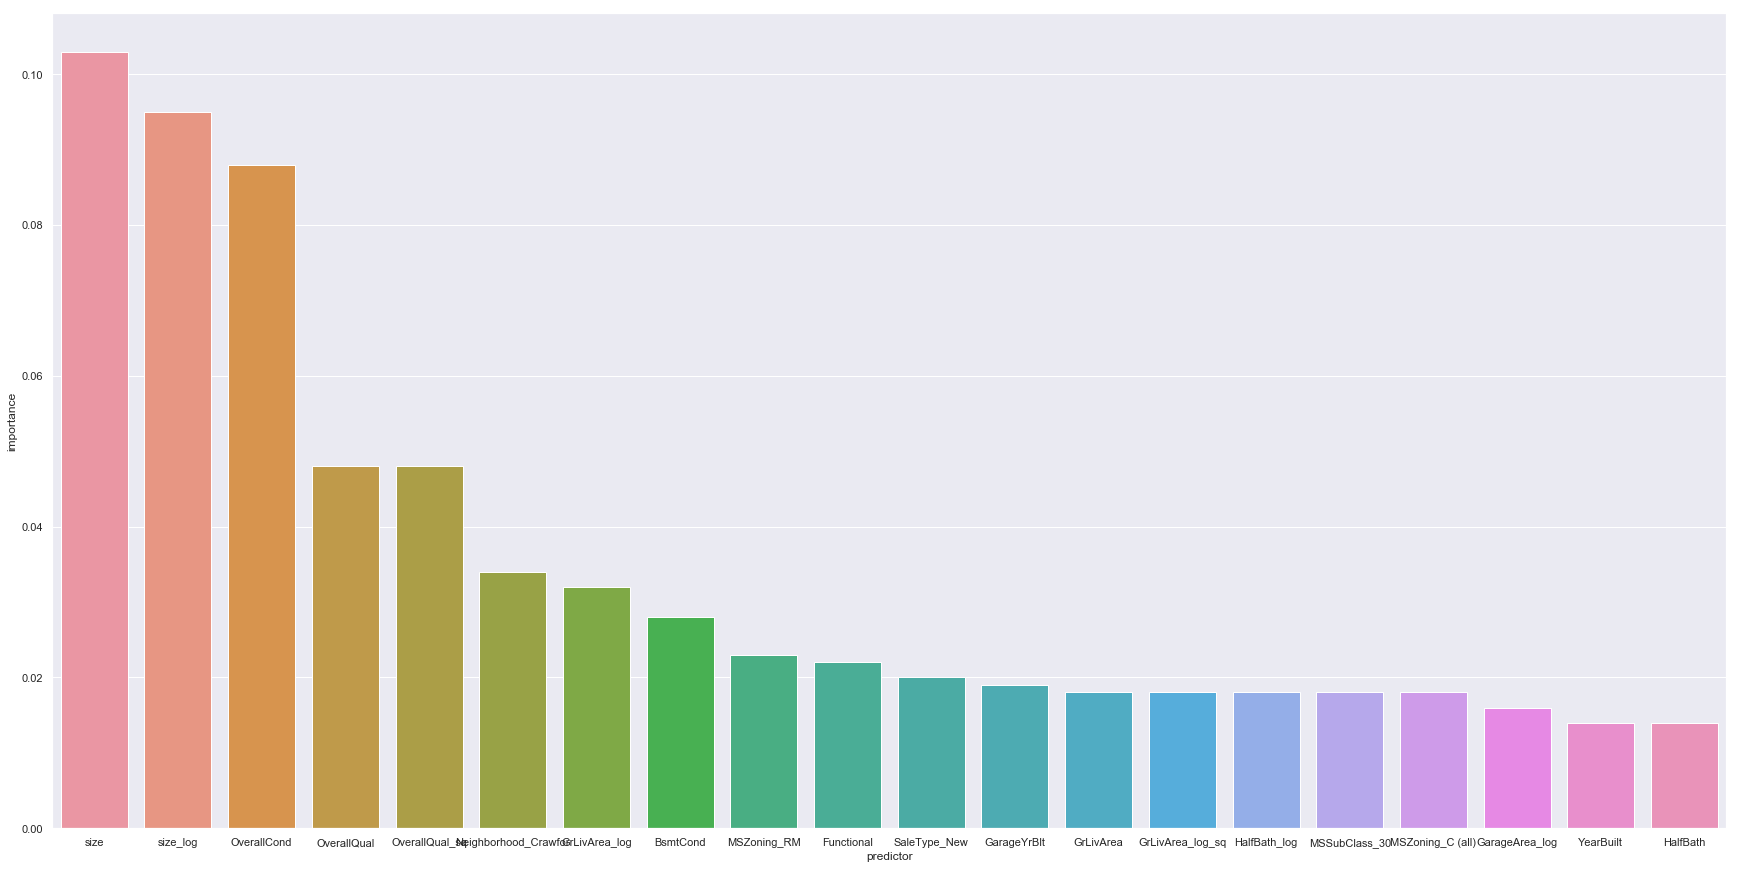

In [682]:
importance = pd.Series(p.feature_importances_, index=train_X.columns).sort_values(ascending=False)
bar_df = pd.DataFrame({'importance' : importance, 'predictor': importance.index})

_, ax = plt.subplots(figsize=(30, 15))
sns.barplot(x='predictor', y='importance', data=bar_df.iloc[0:20,:], ax=ax)

In [569]:
# ideas 
# investigate the `quality` predictors

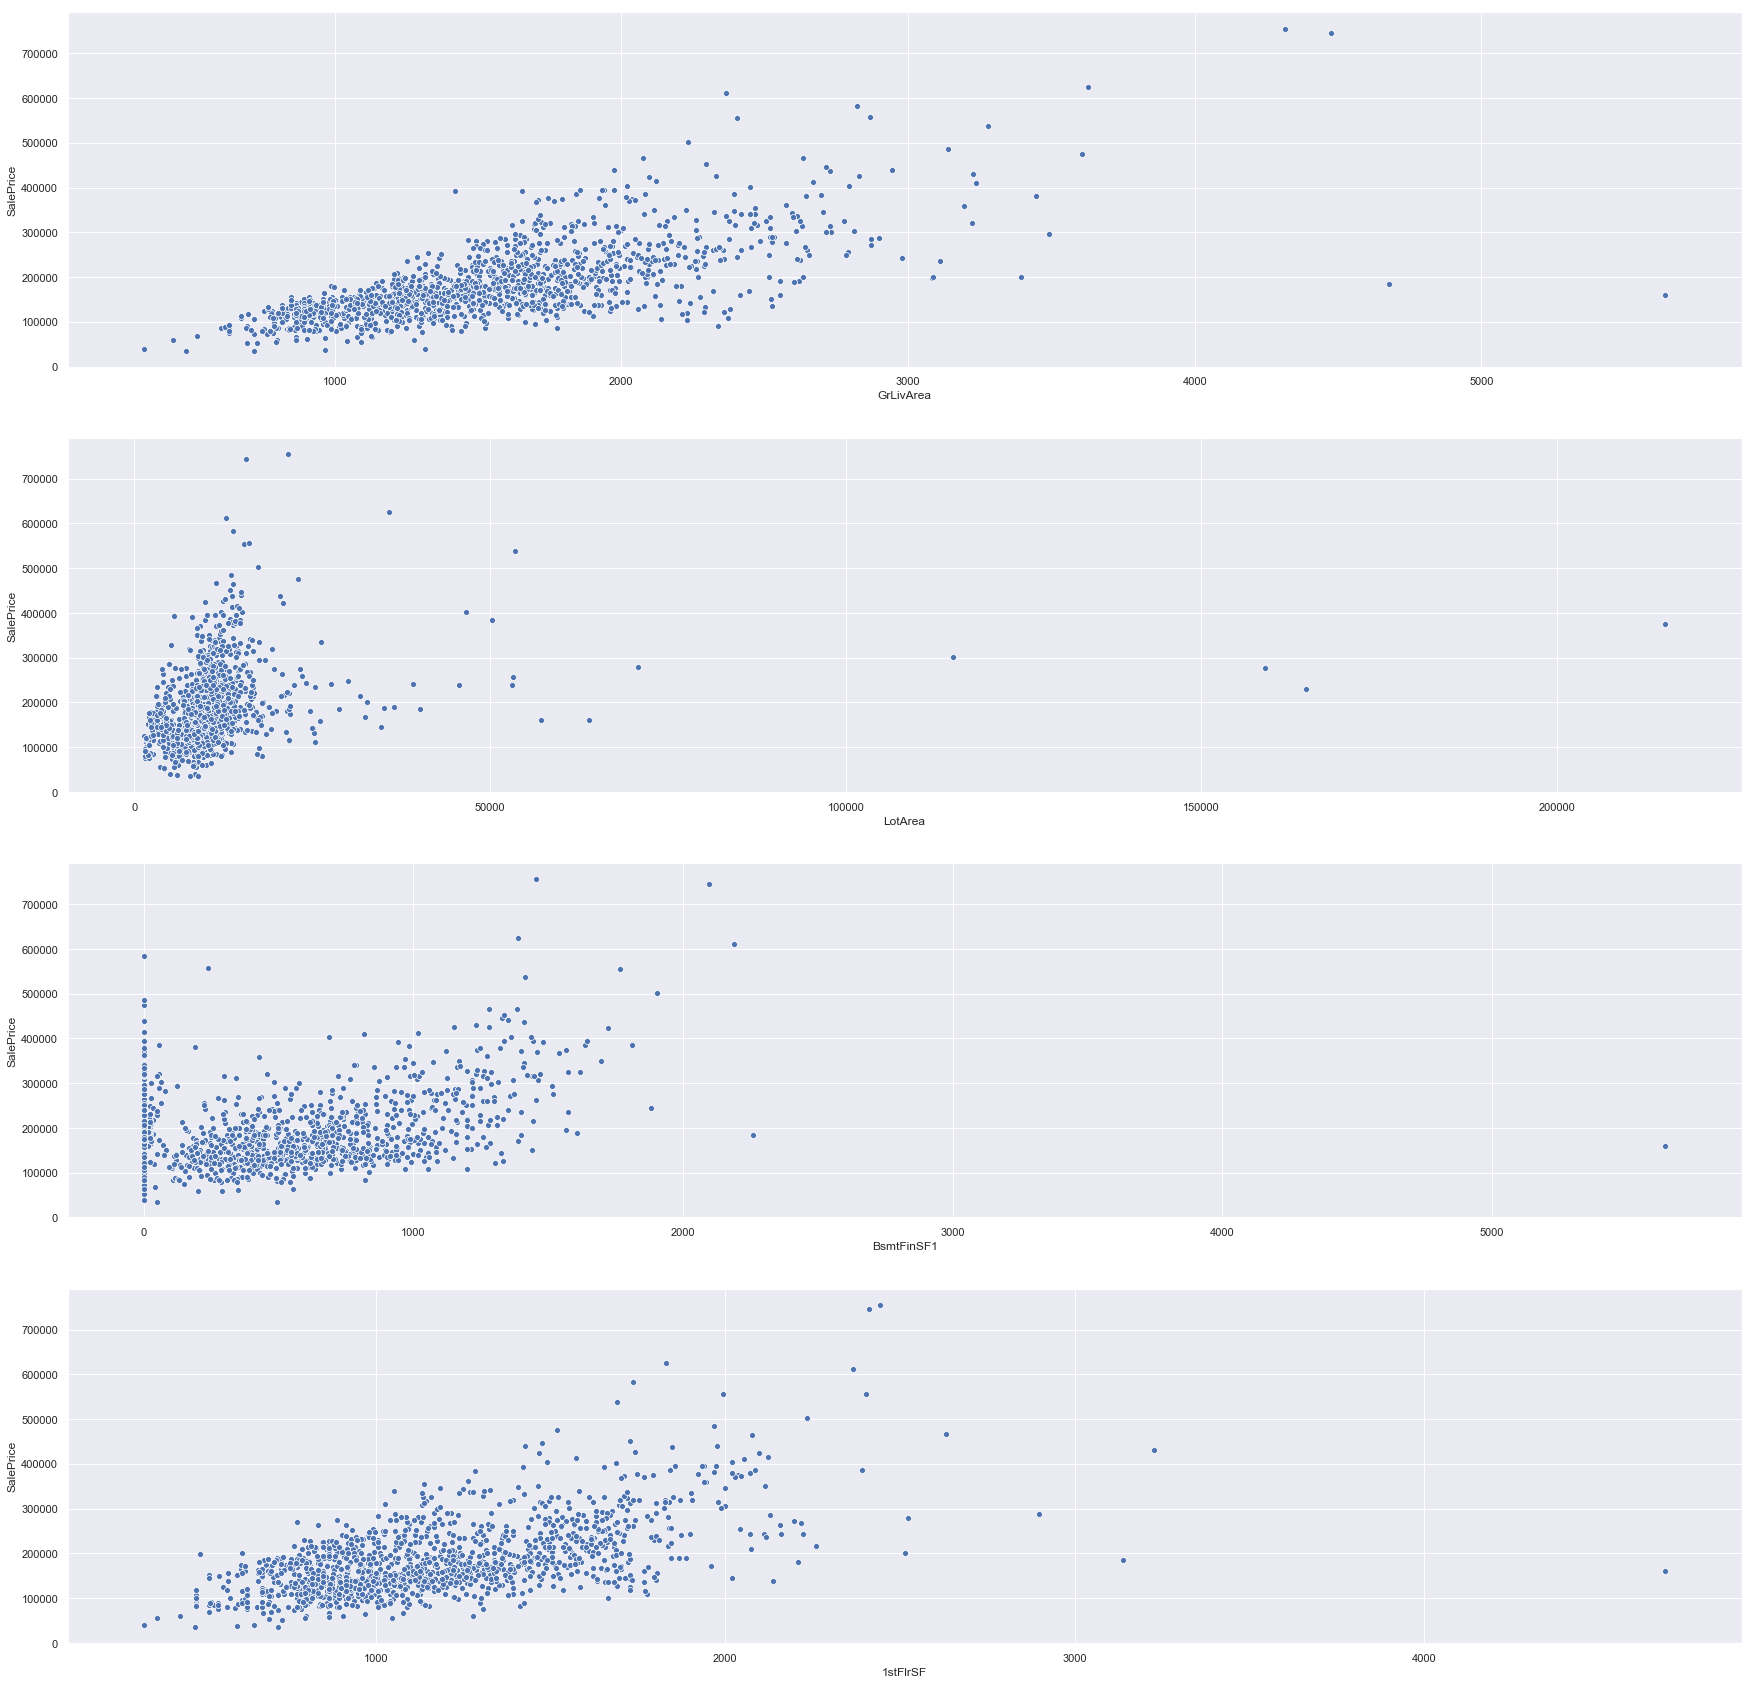

In [683]:
area = ['GrLivArea', 'LotArea', 'BsmtFinSF1','1stFlrSF']
_, ax = plt.subplots(figsize=(30, 30), nrows=4)
for idx, a in enumerate(area):
    sns.scatterplot(x=a, y='SalePrice', data=train_data, ax=ax[idx])

In [598]:
size_predictors = (train_data[area] - train_data[area].mean()) / train_data[area].std()
pca = decomposition.PCA()
pca.fit(size_predictors)
first_pc = pca.components_[0]
size = size_predictors @ first_pc
size = size + abs(size.min())

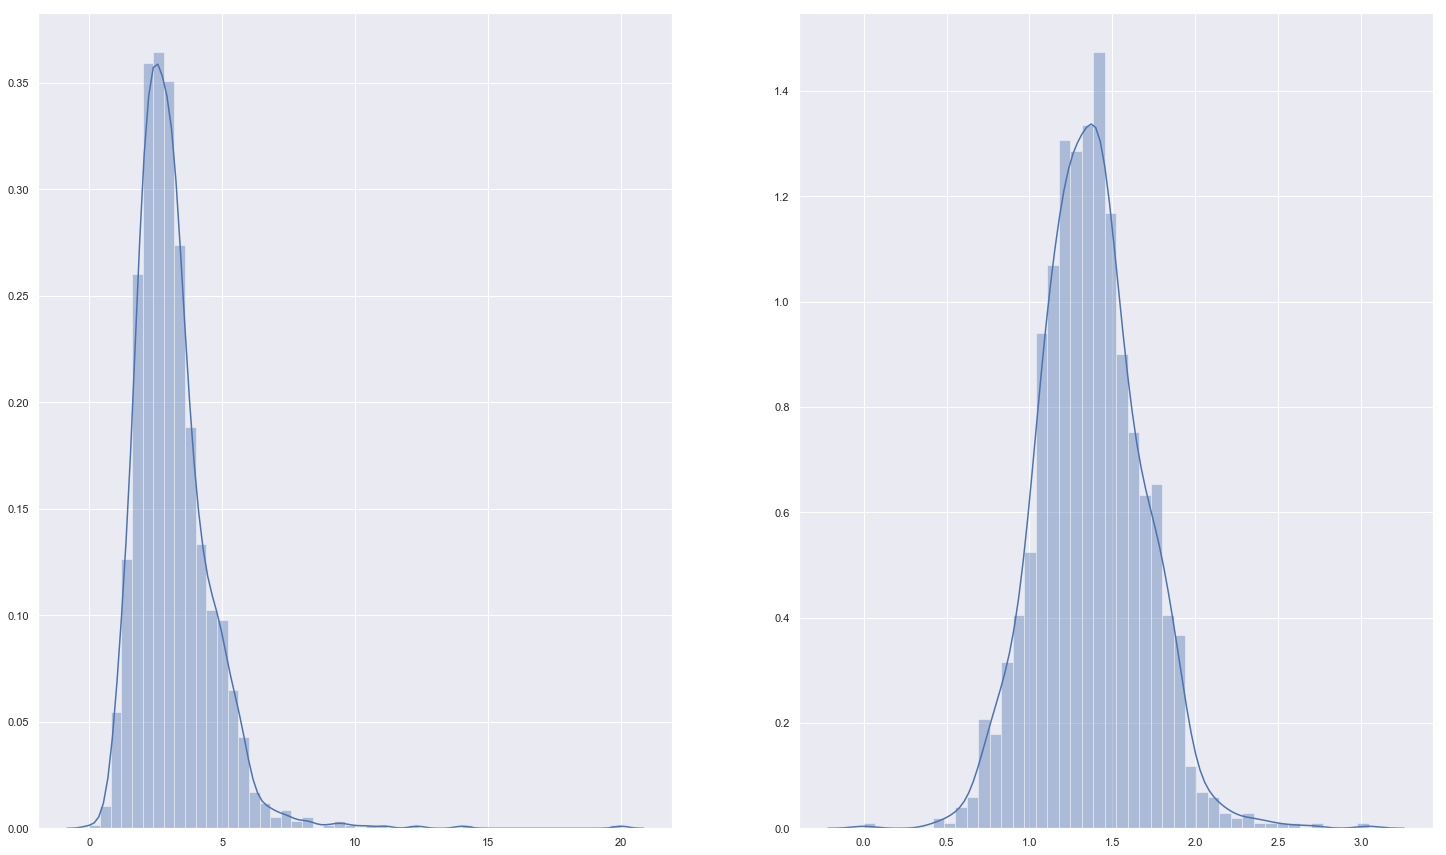

In [627]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,15))
sns.distplot(size, ax=ax1)
sns.distplot(np.log(size + 1), ax=ax2)

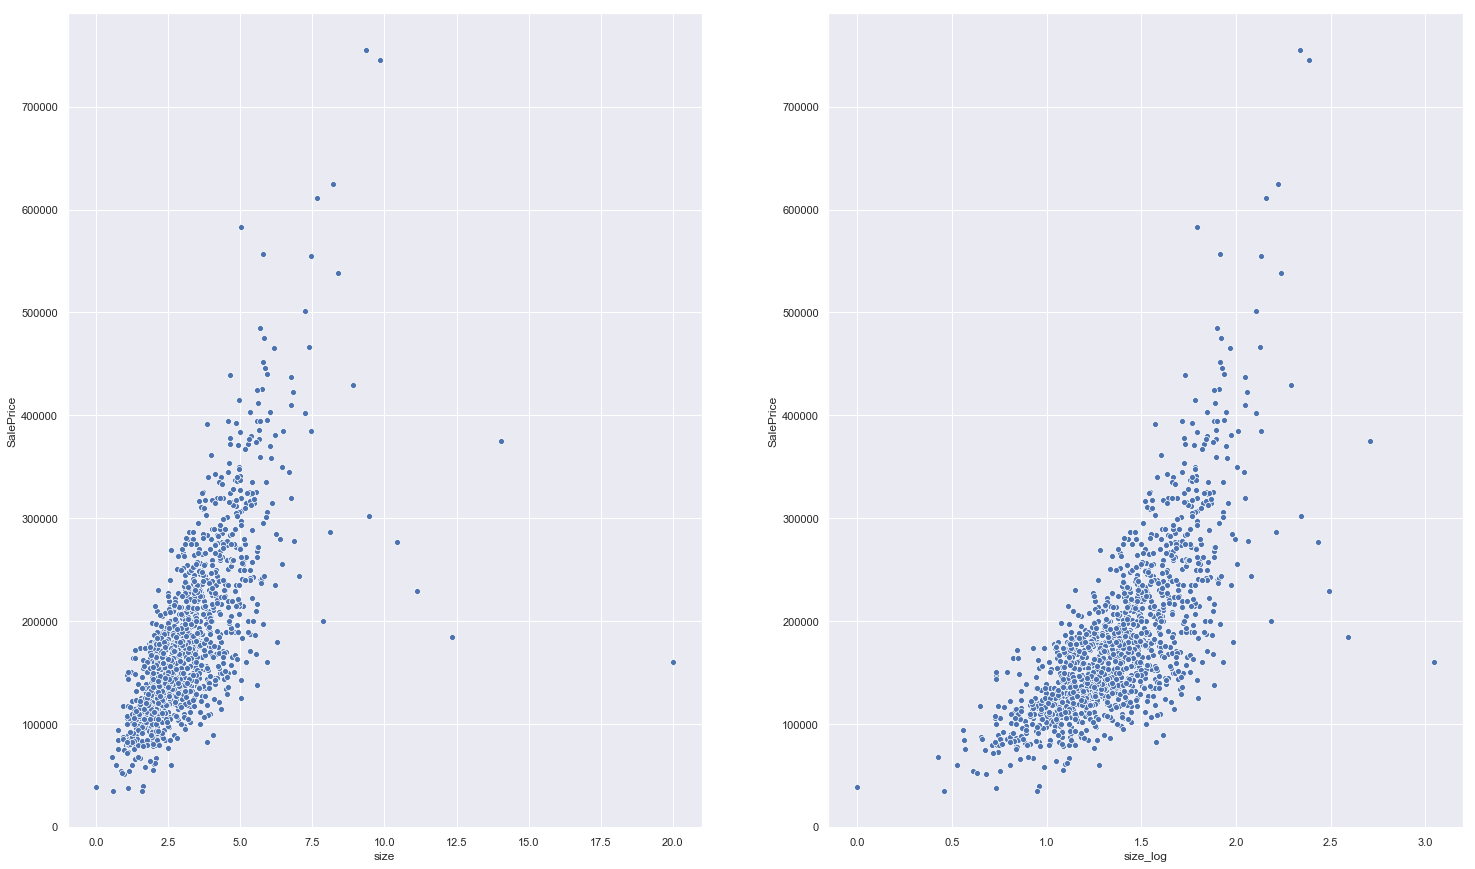

In [673]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,15))
scatter_df = pd.DataFrame({'size' : size,
                           'size_log' : np.log(size + 1),
                           'SalePrice' : train_data['SalePrice']})
sns.scatterplot(x='size', y='SalePrice', data=scatter_df, ax=ax1)
sns.scatterplot(x='size_log', y='SalePrice', data=scatter_df, ax=ax2)

In [ ]:
# -> quality predictor..
# then.. is there an interaction between size and quality that is predictive of saleprice?

### Preprocessing II / Pipeline

- one-hot encoding for categoricals
- log transform `SalePrice`
- log transform skewed predictors
- add squares of predictors with non-linear relationships with `SalePrice`
- ?remove outliers
- ?add engineered features

In [6]:
def extract_categorical(series):
    df = pd.get_dummies(series)
    df.columns = ['{}_{}'.format(series.name, c) for c in df.columns]
    return df

def extract_categoricals(X, categoricals):
    ret = pd.DataFrame()
    for cat in categoricals:
        df = extract_categorical(X[cat])
        ret = pd.concat([ret, df], axis=1)
    return ret
        
extract_categoricals(impute_missing(train_data), categoricals).head()

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_missing
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [7]:
def preprocessing_remove_outliers(X, y):
    outliers_1 = (X['OverallQual'] == 4) & (y > 200000)
    outliers_2 = (X['GrLivArea'] > 4000) & (y < 200000)
    outliers = outliers_1 | outliers_2
    return X[~outliers], y[~outliers]

In [8]:
def preprocessing_extract_predictors(X):
    X = impute_missing(X)
    ordinals_df = extract_ordinals(X)
    categoricals_df = extract_categoricals(X, categoricals)
    numericals_df = X[numericals]
    X = pd.concat([ordinals_df, categoricals_df, numericals_df], axis=1)
    return X

In [9]:
log_predictors = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                  'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                  'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                  'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                  'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd']

def preprocessing_add_log_predictors(X):
    X = X.copy()
    for p in log_predictors:
        X[p + '_log'] = np.log(1 + X[p])
    return X

def preprocessing_replace_log_predictors(X):
    X = X.copy()
    for p in log_predictors:
        X[p] = np.log(1 + X[p])
    return X

In [10]:
square_predictors = ['YearRemodAdd', 'LotFrontage_log', 'TotalBsmtSF_log', '1stFlrSF_log',
                     '2ndFlrSF_log', 'GrLivArea_log', 'GarageCars_log', 'GarageArea_log',
                     'OverallQual', 'BsmtQual','GarageQual','FireplaceQu','KitchenQual']

def preprocessing_add_square_predictors(X):
    X = X.copy()
    for p in square_predictors:
        X[p + '_sq'] = X[p] ** 2
    return X

In [674]:
important_size_predictors = ['GrLivArea', 'LotArea', 'BsmtFinSF1','1stFlrSF']

def preprocessing_add_size_features(X):
    X = X.copy()
    df = X[important_size_predictors]
    size_predictors = (df - df.mean()) / df.std()
    pca = decomposition.PCA()
    pca.fit(size_predictors)
    first_pc = pca.components_[0]
    size = size_predictors @ first_pc
    size = size + abs(size.min())
    size_log = np.log(size + 1)
    X['size'] = size
    X['size_log'] = size_log
    return X

In [675]:
def preprocessing_pipeline_train(X, y):
    X, y = preprocessing_remove_outliers(X, y)
    X = preprocessing_extract_predictors(X)
    X = preprocessing_add_log_predictors(X)
    X = preprocessing_add_square_predictors(X)
    X = preprocessing_add_size_features(X)
    return X.reindex(sorted(X.columns), axis=1), np.log(y)

def preprocessing_pipeline_test(X, train_columns):
    # Handle predictor values in test that are not in train:
    X['MSSubClass'] = X['MSSubClass'].apply(lambda x: 160 if x == 150 else x)
    # Perform identical preprocessing of predictors as train:
    X = preprocessing_extract_predictors(X)
    X = preprocessing_add_log_predictors(X)
    X = preprocessing_add_square_predictors(X)
    X = preprocessing_add_size_features(X)
    X = X.reindex(sorted(X.columns), axis=1)
    # Handle predictor values in train that are not in test:
    missing_cols = set(train_columns).difference(X.columns)
    patch = np.zeros((X.shape[0],len(missing_cols)))
    X = pd.concat([X, pd.DataFrame(patch, columns=missing_cols)], axis=1)
    return X.reindex(sorted(X.columns), axis=1)
    
labelled_X, labelled_y = preprocessing_pipeline_train(train_data.drop(['SalePrice'], axis=1), train_data['SalePrice'])

### Training - Single Models

#### Linear Regression

In [676]:
err = model_selection.cross_val_score(linear_model.LinearRegression(), labelled_X, labelled_y, scoring='neg_mean_squared_error', cv=5)
rmse = (-1 * err) ** 0.5
rmse.mean()

0.12488902268798788

#### L1 and L2

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

{'m__alpha': 0.00044489795918367344}
0.10855800873767413


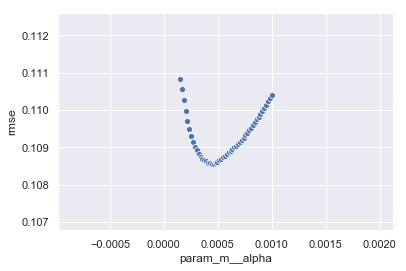

In [677]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso())]) 
param_grid = [{'m__alpha' : np.linspace(0.00015, 0.001, 50)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(labelled_X, labelled_y)
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [ ]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Ridge())])
param_grid = [{'m__alpha' : np.linspace(0.01, 20, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(labelled_X, labelled_y)

In [ ]:
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)

rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [ ]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.ElasticNet())])
param_grid = [{'m__alpha' : np.linspace(0.001, 1, 25),
               'm__l1_ratio' : np.linspace(0.2, 0.8, 11)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(labelled_X, labelled_y)

In [ ]:
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5

best_alpha = srch.best_params_['m__alpha']
best_l1_ratio = srch.best_params_['m__l1_ratio']
best_error = (-1 * srch.best_score_) ** 0.5
print('best combo: \n alpha: {}, \n ratio: {} \n error = {}'.format(best_alpha, best_l1_ratio, best_error))

# plot contours of hyperparamater space
xx = rdf['param_m__alpha'].values.reshape(25, 11)
yy = rdf['param_m__l1_ratio'].values.reshape(25, 11)
zz = rdf['rmse'].values.reshape(25,11)
plt.contourf(xx,yy,zz)
plt.colorbar()

#### Trees

In [20]:
p = ensemble.GradientBoostingRegressor(loss='huber', n_estimators=1000)
param_grid = [{'max_depth' : [1,2],
               'learning_rate' : np.linspace(0.01, 0.2, 5)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False, n_jobs=-1)
srch.fit(labelled_X, labelled_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [1, 2], 'learning_rate': array([0.01  , 0.0575, 0.105 , 0.1525, 0.2   ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [22]:
best_depth = srch.best_params_['max_depth']
best_lr = srch.best_params_['learning_rate']
best_error = (-1 * srch.best_score_) ** 0.5
print('best combo: \n depth: {}, \n learning_rate: {} \n error = {}'.format(best_depth, best_lr, best_error))

best combo: 
 depth: 1, 
 learning_rate: 0.105 
 error = 0.1168400508505328


In [66]:
p = ensemble.RandomForestRegressor(n_estimators=1000)
param_grid = [{'max_features' : ['auto', 'sqrt']}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False, n_jobs=-1)
srch.fit(labelled_X, labelled_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_features': ['auto', 'sqrt']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [67]:
print(srch.best_params_)
best_error = (-1 * srch.best_score_) ** 0.5
print(best_error)

{'max_features': 'auto'}
0.1362654081369651


### Training - Stacking (attempt 1)

In [289]:
rest_X, test_X, rest_y, test_y = model_selection.train_test_split(labelled_X, labelled_y, test_size=0.2)
train_X, val_X, train_y, val_y = model_selection.train_test_split(rest_X, rest_y, test_size=0.2)

#### L1 and L2

In [290]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso())]) 
param_grid = [{'m__alpha' : np.linspace(0.00015, 0.001, 50)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(labelled_X, labelled_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('m', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'m__alpha': array([0.00015, 0.00017, 0.00018, 0.0002 , 0.00022, 0.00024, 0.00025,
       0.00027, 0.00029, 0.00031, 0.00032, 0.00034, 0.00036, 0.00038,
       0.00039, 0.00041, 0.00043, 0.00044, 0.00046, 0.00048, 0.0005 ,
       0.00051, 0.00053, 0.00055, 0.00057, 0.00058, 0.0006 , 0.00...4, 0.00086,
       0.00088, 0.0009 , 0.00091, 0.00093, 0.00095, 0.00097, 0.00098,
       0.001  ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

{'m__alpha': 0.0006010204081632653}
0.11165786453973411


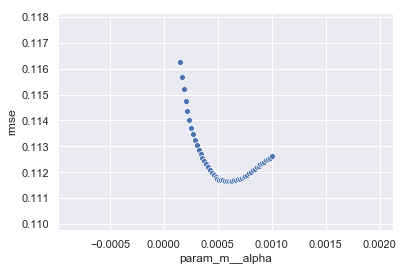

In [291]:
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)

rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [292]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Ridge())])
param_grid = [{'m__alpha' : np.linspace(0.01, 20, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(labelled_X, labelled_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('m', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'m__alpha': array([1.00000e-02, 2.11919e-01, ..., 1.97981e+01, 2.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

{'m__alpha': 16.971212121212123}
0.11362585981741062


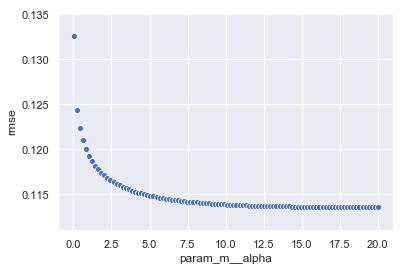

In [293]:
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)

rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [294]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.ElasticNet())])
param_grid = [{'m__alpha' : np.linspace(0.001, 1, 25),
               'm__l1_ratio' : np.linspace(0.2, 0.8, 11)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(labelled_X, labelled_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('m', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'m__alpha': array([0.001  , 0.04263, 0.08425, 0.12588, 0.1675 , 0.20913, 0.25075,
       0.29237, 0.334  , 0.37563, 0.41725, 0.45888, 0.5005 , 0.54213,
       0.58375, 0.62538, 0.667  , 0.70863, 0.75025, 0.79187, 0.8335 ,
       0.87513, 0.91675, 0.95838, 1.     ]), 'm__l1_ratio': array([0.2 , 0.26, 0.32, 0.38, 0.44, 0.5 , 0.56, 0.62, 0.68, 0.74, 0.8 ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

best combo: 
 alpha: 0.001, 
 ratio: 0.56 
 error = 0.11165868624093447


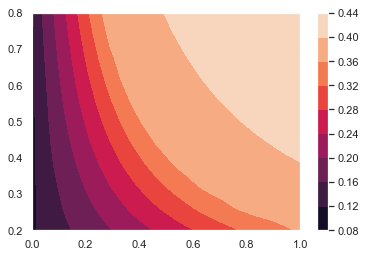

In [295]:
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5

best_alpha = srch.best_params_['m__alpha']
best_l1_ratio = srch.best_params_['m__l1_ratio']
best_error = (-1 * srch.best_score_) ** 0.5
print('best combo: \n alpha: {}, \n ratio: {} \n error = {}'.format(best_alpha, best_l1_ratio, best_error))

# plot contours of hyperparamater space
xx = rdf['param_m__alpha'].values.reshape(25, 11)
yy = rdf['param_m__l1_ratio'].values.reshape(25, 11)
zz = rdf['rmse'].values.reshape(25,11)
plt.contourf(xx,yy,zz)
plt.colorbar()

In [296]:
p = ensemble.GradientBoostingRegressor(max_depth=1, loss='huber', n_estimators=10000).fit(train_X, train_y)
param_grid = [{'learning_rate' : [0.015]}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False, n_jobs=-1)
srch.fit(labelled_X, labelled_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'learning_rate': [0.015]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [297]:
best_lr = srch.best_params_['learning_rate']
best_error = (-1 * srch.best_score_) ** 0.5
print('best combo: \n learning_rate: {} \n error = {}'.format(best_lr, best_error))

best combo: 
 learning_rate: 0.015 
 error = 0.12065399057027622


In [298]:
p = ensemble.RandomForestRegressor(n_estimators=500).fit(train_X, train_y)
param_grid = [{'max_features' : ['sqrt']}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False, n_jobs=-1)
srch.fit(labelled_X, labelled_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_features': ['sqrt']}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [299]:
print(srch.best_params_)
best_error = (-1 * srch.best_score_) ** 0.5
print(best_error)

{'max_features': 'sqrt'}
0.1463217317982681


In [300]:
l1 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                        ('m', linear_model.Lasso(alpha=0.0006530612244897959))]).fit(train_X, train_y)

l2 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                        ('m', linear_model.Ridge(alpha=5.663737373737374))]).fit(train_X, train_y)

gbr = ensemble.GradientBoostingRegressor(max_depth=1, learning_rate=0.015, loss='huber', n_estimators=10000).fit(train_X, train_y)

fr = ensemble.RandomForestRegressor(n_estimators=500).fit(train_X, train_y)

In [301]:
l1_pred = l1.predict(val_X)
l2_pred = l2.predict(val_X)
gbr_pred = gbr.predict(val_X)
fr_pred = fr.predict(val_X)
stack_df = pd.DataFrame({'l1' : l1_pred, 'l2': l2_pred, 'gbr' : gbr_pred, 'fr' : fr_pred})
stack_df.index = val_X.index
stack_df = pd.concat([stack_df, val_X], axis=1)

In [302]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso())]) 
param_grid = [{'m__alpha' : np.linspace(0.00015, 0.05, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(stack_df, val_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('m', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'m__alpha': array([0.00015, 0.00065, ..., 0.0495 , 0.05   ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

{'m__alpha': 0.005185353535353536}
0.10613982296128052


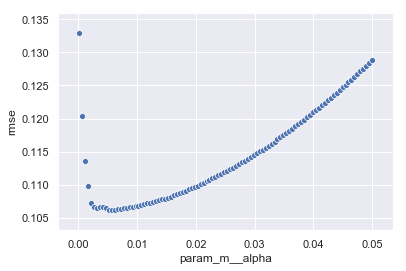

In [303]:
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)

rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [308]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Ridge())])
param_grid = [{'m__alpha' : np.linspace(0.01, 20, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(stack_df, val_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('m', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'m__alpha': array([1.00000e-02, 2.11919e-01, ..., 1.97981e+01, 2.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

{'m__alpha': 8.086767676767677}
0.11716012087163609


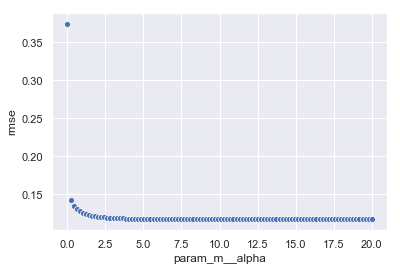

In [309]:
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)

rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [310]:
p = ensemble.GradientBoostingRegressor(max_depth=1, loss='huber', n_estimators=10000).fit(train_X, train_y)
param_grid = [{'learning_rate' : [0.015]}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False, n_jobs=-1)
srch.fit(stack_df, val_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'learning_rate': [0.015]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [311]:
best_lr = srch.best_params_['learning_rate']
best_error = (-1 * srch.best_score_) ** 0.5
print('best combo: \n learning_rate: {} \n error = {}'.format(best_lr, best_error))

best combo: 
 learning_rate: 0.015 
 error = 0.12158738367850455


### Training - Stacking (attempt 2)

In [457]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(labelled_X, labelled_y, test_size=0.2)

#### Hyperparamter searches for base models

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

{'m__alpha': 0.0006530612244897959}
0.11025366532012265


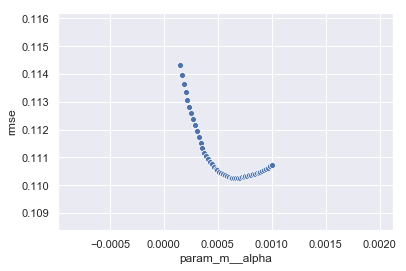

In [424]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso())]) 
param_grid = [{'m__alpha' : np.linspace(0.00015, 0.001, 50)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(train_X, train_y)
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

#### Generate train_meta

In [458]:
def gen_train_meta(train_X, train_y):
    train_meta = pd.DataFrame()
    for train_fld_idx, test_fld_idx in model_selection.KFold(n_splits=5).split(train_X):
        train_folds_X, test_fold_X = train_X.iloc[train_fld_idx], train_X.iloc[test_fld_idx]
        train_folds_y, test_fold_y = train_y.iloc[train_fld_idx], train_y.iloc[test_fld_idx]

        # TODO: up the n_estimators before evaluation / submission
        l1 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                                ('m', linear_model.Lasso(alpha=0.0006530612244897959))]).fit(train_folds_X, train_folds_y)
    
        gbr = ensemble.GradientBoostingRegressor(max_depth=1, learning_rate=0.015, loss='huber', n_estimators=1000).fit(train_folds_X, train_folds_y)

        rf = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt').fit(train_folds_X, train_folds_y)
    
        l1_preds = l1.predict(test_fold_X)
        gbr_preds = gbr.predict(test_fold_X)
        rf_preds = rf.predict(test_fold_X)
        df = pd.DataFrame({'l1' : l1_preds, 'gbr' : gbr_preds, 'rf' : rf_preds})
        df.index = test_fold_X.index
        train_meta = train_meta.append(df)
    return train_meta

train_meta = gen_train_meta(train_X, train_y)

#### Picking a stacker and its hyperparams

##### Stackers with train_meta

In [476]:
err = model_selection.cross_val_score(linear_model.LinearRegression(), train_meta, train_y, scoring='neg_mean_squared_error', cv=5)
rmse = (-1 * err) ** 0.5
rmse.mean()

0.10876162634581654

{'m__alpha': 1e-06}
0.10954092592931587


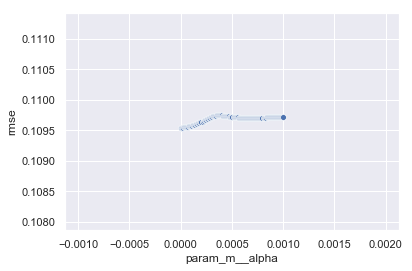

In [483]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso())]) 
param_grid = [{'m__alpha' : np.linspace(0.000001, 0.001, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(train_meta, train_y)
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

{'m__alpha': 1e-06}
0.1095406594624444


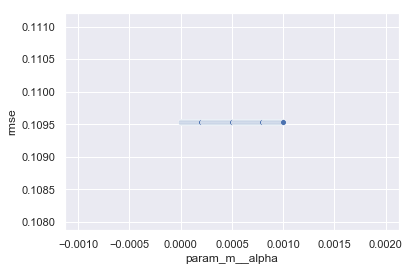

In [507]:
p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Ridge())]) 
param_grid = [{'m__alpha' : np.linspace(0.000001, 0.001, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(train_meta, train_y)
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

#### Stackers with train_meta + original features

In [477]:
err = model_selection.cross_val_score(linear_model.LinearRegression(), train_meta_plus, train_y, scoring='neg_mean_squared_error', cv=5)
rmse = (-1 * err) ** 0.5
rmse.mean()

0.12127414330059996

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

{'m__alpha': 0.00010404040404040404}
0.09238060448409473


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


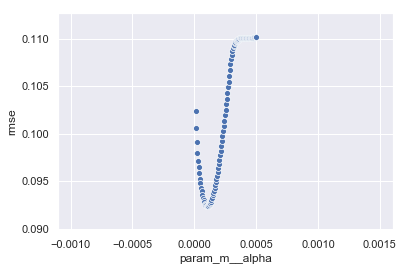

In [471]:
train_meta_plus = pd.concat([train_meta,train_X], axis=1)

p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso())]) 
param_grid = [{'m__alpha' : np.linspace(0.00001, 0.0005, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(train_meta_plus, train_y)
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

{'m__alpha': 0.33366666666666667}
0.09941527211028439


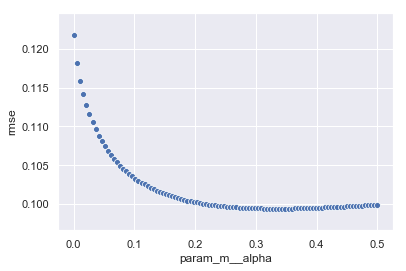

In [498]:
train_meta_plus = pd.concat([train_meta,train_X], axis=1)

p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Ridge())]) 
param_grid = [{'m__alpha' : np.linspace(0.001, 0.5, 100)}]
srch = model_selection.GridSearchCV(p, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=False)
srch.fit(train_meta_plus, train_y)
print(srch.best_params_)
print((-1 * srch.best_score_) ** 0.5)
rdf = pd.DataFrame(srch.cv_results_)
rdf['rmse'] =  (-1 * rdf['mean_test_score']) ** 0.5
sns.scatterplot(x='param_m__alpha', y='rmse', data=rdf)

In [514]:
p = ensemble.GradientBoostingRegressor(learning_rate=0.015, max_depth=1, loss='huber', n_estimators=10000)
err = model_selection.cross_val_score(p, train_meta_plus, train_y, scoring='neg_mean_squared_error', cv=5)
rmse = (-1 * err) ** 0.5
rmse.mean()

0.12523347922876

#### Evaluate Models

In [510]:
def stacked_error(stacker, meta_fn):
    l1 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                        ('m', linear_model.Lasso(alpha=0.0006530612244897959))]).fit(train_X, train_y)
    
    gbr = ensemble.GradientBoostingRegressor(max_depth=1, learning_rate=0.015, loss='huber', n_estimators=1000).fit(train_X, train_y)
    rf = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt').fit(train_X, train_y)
    l1_preds = l1.predict(test_X)
    gbr_preds = gbr.predict(test_X)
    rf_preds = rf.predict(test_X)
    df = pd.DataFrame({'l1' : l1_preds, 'gbr' : gbr_preds, 'rf' : rf_preds})
    preds = stacker.predict(meta_fn(df))
    return np.square(test_y - preds).mean() ** 0.5

#### Stackers with train_meta

In [511]:
# train_meta w/o original features

lr_stacker = linear_model.LinearRegression().fit(train_meta, train_y)
print(stacked_error(lr_stacker, lambda x: x))

0.10760758679170207


#### Stacker with train_meta + original features

In [513]:
# train_meta wi/ original features

def meta_fn(meta_df):
    meta_df.index = test_X.index
    return pd.concat([meta_df, test_X], axis=1)
    
train_meta_plus = pd.concat([train_meta,train_X], axis=1)

lasso_stacker = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                                   ('m', linear_model.Lasso(alpha=0.00010404040404040404, max_iter=5000))]).fit(train_meta_plus, train_y)

print(stacked_error(lasso_stacker, meta_fn))

ridge_stacker = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                                   ('m', linear_model.Ridge(alpha=0.33366666666666667, max_iter=5000))]).fit(train_meta_plus, train_y)

print(stacked_error(ridge_stacker, meta_fn))

0.11498813027397785
0.11936130846784265


### Submission - Single Models

In [132]:
# Fit model on all labelled data
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']
train_X, train_y = preprocessing_pipeline_train(X, y)

#p = pipeline.Pipeline([('scale', preprocessing.RobustScaler()),('m', linear_model.Lasso(0.0004275510204081633))]) 
#p = linear_model.Lasso(0.0004275510204081633)
#p = ensemble.GradientBoostingRegressor(learning_rate=0.105, max_depth=1, loss='huber', n_estimators=1000).fit(train_X, train_y)
p = ensemble.RandomForestRegressor(n_estimators=1000).fit(train_X, train_y)

p.fit(train_X, train_y)

# Make predictions on unlabelled data
test_X = preprocessing_pipeline_test(test_data, train_X.columns)
preds = p.predict(test_X)
exp_preds = np.exp(preds)

# Write submission file
submission = pd.concat([test_data['Id'],pd.DataFrame(exp_preds, columns=['SalePrice'])], axis=1)
submission.to_csv('submit_rf.csv', index=False)

### Submission - Stacking (attempt 1)

In [ ]:
# Split labelled data for stacking
labelled_X, labelled_y = preprocessing_pipeline_train(train_data.drop(['SalePrice'], axis=1), train_data['SalePrice'])
train_X, val_X, train_y, val_y = model_selection.train_test_split(labelled_X, labelled_y, test_size=0.2)

# Fit base models on training set
l1 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                        ('m', linear_model.Lasso(alpha=0.0006530612244897959))]).fit(train_X, train_y)

l2 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                        ('m', linear_model.Ridge(alpha=5.663737373737374))]).fit(train_X, train_y)

gbr = ensemble.GradientBoostingRegressor(max_depth=1, learning_rate=0.015, loss='huber', n_estimators=10000).fit(train_X, train_y)

fr = ensemble.RandomForestRegressor(n_estimators=500).fit(train_X, train_y)

# Make predictions on validation set
l1_pred = l1.predict(val_X)
l2_pred = l2.predict(val_X)
gbr_pred = gbr.predict(val_X)
fr_pred = fr.predict(val_X)
stack_df = pd.DataFrame({'l1' : l1_pred, 'l2': l2_pred, 'gbr' : gbr_pred, 'fr' : fr_pred})
stack_df.index = val_X.index
stack_df = pd.concat([stack_df, val_X], axis=1)

# Fit stacking model 
stacker = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                       ('m', linear_model.Lasso(0.006192424242424243))]) 
stacker.fit(stack_df, val_y)

# Make predictions on test set

test_X = preprocessing_pipeline_test(test_data, train_X.columns)

l1_pred = l1.predict(test_X)
l2_pred = l2.predict(test_X)
gbr_pred = gbr.predict(test_X)
fr_pred = fr.predict(test_X)
stack_df = pd.DataFrame({'l1' : l1_pred, 'l2': l2_pred, 'gbr' : gbr_pred, 'fr' : fr_pred})
stack_df.index = test_X.index
stack_df = pd.concat([stack_df, test_X], axis=1)

preds = stacker.predict(stack_df)
exp_preds = np.exp(preds)
# Write submission file
submission = pd.concat([test_data['Id'],pd.DataFrame(exp_preds, columns=['SalePrice'])], axis=1)
submission.to_csv('submit_stacker.csv', index=False)

### Submission - Stacking (attempt 2)

In [519]:
labelled_X, labelled_y = preprocessing_pipeline_train(train_data.drop(['SalePrice'], axis=1), train_data['SalePrice'])

train_meta = gen_train_meta(labelled_X, labelled_y)
train_meta_plus = pd.concat([train_meta, labelled_X], axis=1)

stacker = linear_model.LinearRegression().fit(train_meta, labelled_y)

l1 = pipeline.Pipeline([('scale', preprocessing.RobustScaler()), 
                        ('m', linear_model.Lasso(alpha=0.0006530612244897959))]).fit(labelled_X, labelled_y)
    
gbr = ensemble.GradientBoostingRegressor(max_depth=1, learning_rate=0.015, loss='huber', n_estimators=1000).fit(labelled_X, labelled_y)

rf = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt').fit(labelled_X, labelled_y)


test_X = preprocessing_pipeline_test(test_data, train_X.columns)

l1_preds = l1.predict(test_X)
gbr_preds = gbr.predict(test_X)
rf_preds = rf.predict(test_X)
meta_df = pd.DataFrame({'l1' : l1_preds, 'gbr' : gbr_preds, 'rf' : rf_preds})
#meta_df.index = test_X.index
#meta_df_plus = pd.concat([meta_df, test_X], axis=1)
preds = stacker.predict(meta_df)

In [520]:
exp_preds = np.exp(preds)
# Write submission file
submission = pd.concat([test_data['Id'],pd.DataFrame(exp_preds, columns=['SalePrice'])], axis=1)
submission.to_csv('submit_stacker.csv', index=False)

### Submission - Blending

In [142]:
lasso = pd.read_csv('submit_lasso.csv')
gbr = pd.read_csv('submit_gbr.csv')
stack_df = pd.DataFrame([lasso['SalePrice'], gbr['SalePrice']]).T

In [143]:
# arithmetic mean
stack_avg = stack_df.mean(axis=1)
#stack_avg = (lasso['SalePrice'] * gbr['SalePrice']) ** 0.5
submit_df = pd.DataFrame({'Id' : test_data['Id'], 'SalePrice' : stack_avg})
submit_df.to_csv('submit_blend.csv', index=False)

In [ ]:
# TODO

# - add indicator variables for variables with step changes
# - more feature engineering / preprocessing
# - look at residual plots, important tree predictors: clean up thos variables: anomaly detect add polynomials..

# - What to do about expensive hyperparamater searches / training?
# -- ? workflow for offloading to aws/goog cloud
# -- ? alternatives to GridSearch: Bayseian optimization looks promising


# - How can you speed up this workflow?
# - How would this workflow work if there were 10^8 rows in the training set?

# - What models could you add to your ensmble that are likely to have less correlated errors?